In [1]:
import awkward as ak
import uproot
import hist
import os
import numpy as np
from imp import reload #每次修改调用函数后可以更新
import correctionlib, rich
import matplotlib.pyplot as plt
import sys
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

/tmp/ipykernel_28867/3501001846.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload #每次修改调用函数后可以更新


In [8]:
def load_event_dict(file_prefix, keys):
    data_subkeys = ['reco_photon_pt','gen_infiducial_photon_pt','reco_muon_mass','gen_infiducial_muon_mass','reco_gmumu_mass','gen_infiducial_gmumu_mass','reco_outfiducial_photon_pt','reco_outfiducial_muon_mass','gen_outfiducial_photon_pt','reco_outfiducial_muon_mass']#'gen_offfiducial_muon_mass','photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass','gmumu_mass','dr_lg','npvsGood','Rho_Calo','Rho_tracker'
#    data_subkeys = ['photon_pt', 'photon_eta', 'muon1_pt', 'muon2_pt', 'muon1_eta', 'muon2_eta', 'muon_mass']
    other_subkeys = data_subkeys #'event_weight','generator_weight', 'LHEPdfWeight','LHEScaleWeight','PSWeight','gen_gmumu','gen_mumu','gen_muon1_pt','gen_muon2_pt','gen_muon1_eta','gen_muon2_eta'
    
    event_dict = {}
    for key in keys:
        subkeys = other_subkeys if 'data' not in key else data_subkeys
        event_dict[key] = {}
        for subkey in subkeys:
            event_dict[key][subkey] = ak.from_parquet(f'{file_prefix}_{key}_{subkey}.parquet')
    return event_dict

In [9]:
keys = ['zg2','zg3']  #'zg0', 'zg1',
# keys = ['tt']  
# keys = ['zg0']  
# 读取数据
fiducial_final = load_event_dict('../fiducial_file/fiducial_final', keys)


In [10]:
fiducial_final

{'zg2': {'reco_photon_pt': <Array [[142], [108], ... [192], [167]] type='26700 * option[var * float32]'>,
  'gen_infiducial_photon_pt': <Array [[142], [105], ... [192], [168]] type='26700 * option[var * float32]'>,
  'reco_muon_mass': <Array [88.1, 90.7, 92.8, ... 85.5, 93.8, 93.5] type='26700 * ?float32'>,
  'gen_infiducial_muon_mass': <Array [88.6, 89.4, 91.1, ... 86.9, 91.9, 90.6] type='26700 * ?float32'>,
  'reco_gmumu_mass': <Array [365, 216, 393, 218, ... 247, 462, 399] type='26700 * ?float32'>,
  'gen_infiducial_gmumu_mass': <Array [[367], [213], ... [455], [392]] type='26700 * option[var * float32]'>,
  'reco_outfiducial_photon_pt': <Array [[105], [178], ... [108], [168]] type='536 * option[var * float32]'>,
  'reco_outfiducial_muon_mass': <Array [324, 540, 816, 262, ... 249, 262, 378] type='536 * ?float32'>,
  'gen_outfiducial_photon_pt': <Array [[], [176, 10.2], [], ... [108], [], []] type='536 * option[var * float32]'>},
 'zg3': {'reco_photon_pt': <Array [[300], [362], ... [

begin 88701
1 photon+2 muons 87350
Failed after 1 photon+2 muons 1351
abs(eta) < 2.4 87346
Failed after abs(eta) < 2.4 4
pt >= 25,20 87079
Failed after pt >= 25,20 267
opposite charge 87079
Failed after opposite charge 0
photon pt >30 84833
Failed after photon pt >30 2246
photon eta 84782
Failed after photon eta 51
Acceptance : 0.9558178600015783
Total failed events: 3919


In [11]:
lepton = ak.Array(event_final['zg0']['GenDressedLepton'])
photon = ak.Array(event_final['zg0']['GenIsolatedPhoton'])
sample0 = ak.Array(event_final['zg0'])
print('begin',len(sample0))
pass_mu = lepton.pt > 10
pass_pho = photon.pt > 10

# Failed after first selection
failed1 = ak.Array(sample0[~((ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2))])
print('Failed after 1 photon+2 muons',len(failed1))

sample_tem = failed1['GenDressedLepton'][abs(failed1['GenDressedLepton'].eta) < 2.4]
failed2 = failed1[~(ak.num(sample_tem.eta)==2)]
print('Failed after abs(eta) < 2.4',len(failed2))

failed3 = failed2[~((failed2['GenDressedLepton'].pt[:,0]>=25) & (failed2['GenDressedLepton'].pt[:,1]>=20))]
print('Failed after pt >= 25,20',len(failed3))

failed4 = failed3[~(ak.sum(failed3['GenDressedLepton'].pdgId,axis=1)==0)]
print('Failed after opposite charge',len(failed4))

sample_tem = failed4['GenIsolatedPhoton'][failed4['GenIsolatedPhoton'].pt > 30]
failed5 = failed4[~(ak.num(sample_tem.eta)==1)]
print('Failed after photon pt >30',len(failed5))

sample_tem = failed5['GenIsolatedPhoton'][(abs(failed5['GenIsolatedPhoton'].eta) < 2.5) & ~((abs(failed5['GenIsolatedPhoton'].eta) > 1.4442) & (abs(failed5['GenIsolatedPhoton'].eta) < 1.566))]
failed6 = failed5[~(ak.num(sample_tem.eta)==1)]
print('Failed after photon eta',len(failed6))


begin 88701
Failed after 1 photon+2 muons 1351
Failed after abs(eta) < 2.4 633
Failed after pt >= 25,20 0
Failed after opposite charge 0
Failed after photon pt >30 0
Failed after photon eta 0


In [9]:
lepton = ak.Array(event_final['zg1']['GenDressedLepton'])
photon = ak.Array(event_final['zg1']['GenIsolatedPhoton'])
sample0 = ak.Array(event_final['zg1'])
print('begin',len(sample0))
pass_mu = lepton.pt > 10
pass_pho = photon.pt > 10
ak.num(pass_mu)
sample1 = ak.Array(sample0[(ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2)])
print('1 photon+2 muons',len(sample1))
sample_tem = sample1['GenDressedLepton'][abs(sample1['GenDressedLepton'].eta) < 2.4]
sample2 = sample1[ak.num(sample_tem.eta)==2]
print('abs(eta) < 2.4',len(sample2))
sample3 = sample2[(sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20)]
print('pt >= 25,20',len(sample3))
sample4 = sample3[ak.sum(sample3['GenDressedLepton'].pdgId,axis=1)==0]
print('opposite charge',len(sample4))
# mass_mumu = selection_cut.MASS(sample4,'mu')
sample_tem = sample4['GenIsolatedPhoton'][sample4['GenIsolatedPhoton'].pt > 30]
sample5 = sample4[ak.num(sample_tem.eta)==1]
print('photon pt >30',len(sample5))
sample_tem = sample5['GenIsolatedPhoton'][(abs(sample5['GenIsolatedPhoton'].eta) < 2.5) & ~((abs(sample5['GenIsolatedPhoton'].eta) > 1.4442) & (abs(sample5['GenIsolatedPhoton'].eta) < 1.566))]
sample6 = sample5[ak.num(sample_tem.eta)==1]
print('photon eta',len(sample6))
print('Acceptance :', len(sample6)/len(sample0))
# lg_near, lg_dr = sample6['GenIsolatedPhoton'].nearest(sample6['GenDressedLepton'], axis=1, return_metric=True)
# lg_dr
# fsr = selection_cut.muon(pho5,'fsr',lg_dr)

begin 1082106
1 photon+2 muons 1067382
abs(eta) < 2.4 1067334
pt >= 25,20 1063850
opposite charge 1063850
photon pt >30 1063826
photon eta 1063295
Acceptance : 0.9826163056114651


In [10]:
lepton = ak.Array(event_final['zg2']['GenDressedLepton'])
photon = ak.Array(event_final['zg2']['GenIsolatedPhoton'])
sample0 = ak.Array(event_final['zg2'])
print('begin',len(sample0))
pass_mu = lepton.pt > 10
pass_pho = photon.pt > 10
ak.num(pass_mu)
sample1 = ak.Array(sample0[(ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2)])
print('1 photon+2 muons',len(sample1))
sample_tem = sample1['GenDressedLepton'][abs(sample1['GenDressedLepton'].eta) < 2.4]
sample2 = sample1[ak.num(sample_tem.eta)==2]
print('abs(eta) < 2.4',len(sample2))
sample3 = sample2[(sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20)]
print('pt >= 25,20',len(sample3))
sample4 = sample3[ak.sum(sample3['GenDressedLepton'].pdgId,axis=1)==0]
print('opposite charge',len(sample4))
# mass_mumu = selection_cut.MASS(sample4,'mu')
sample_tem = sample4['GenIsolatedPhoton'][sample4['GenIsolatedPhoton'].pt > 30]
sample5 = sample4[ak.num(sample_tem.eta)==1]
print('photon pt >30',len(sample5))
sample_tem = sample5['GenIsolatedPhoton'][(abs(sample5['GenIsolatedPhoton'].eta) < 2.5) & ~((abs(sample5['GenIsolatedPhoton'].eta) > 1.4442) & (abs(sample5['GenIsolatedPhoton'].eta) < 1.566))]
sample6 = sample5[ak.num(sample_tem.eta)==1]
print('photon eta',len(sample6))
print('Acceptance :', len(sample6)/len(sample0))
# lg_near, lg_dr = sample6['GenIsolatedPhoton'].nearest(sample6['GenDressedLepton'], axis=1, return_metric=True)
# lg_dr
# fsr = selection_cut.muon(pho5,'fsr',lg_dr)

begin 27236
1 photon+2 muons 26869
abs(eta) < 2.4 26868
pt >= 25,20 26780
opposite charge 26780
photon pt >30 26780
photon eta 26769
Acceptance : 0.9828535761492143


In [11]:
lepton = ak.Array(event_final['zg3']['GenDressedLepton'])
photon = ak.Array(event_final['zg3']['GenIsolatedPhoton'])
sample0 = ak.Array(event_final['zg3'])
print('begin',len(sample0))
pass_mu = lepton.pt > 10
pass_pho = photon.pt > 10
ak.num(pass_mu)
sample1 = ak.Array(sample0[(ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2)])
print('1 photon+2 muons',len(sample1))
sample_tem = sample1['GenDressedLepton'][abs(sample1['GenDressedLepton'].eta) < 2.4]
sample2 = sample1[ak.num(sample_tem.eta)==2]
print('abs(eta) < 2.4',len(sample2))
sample3 = sample2[(sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20)]
print('pt >= 25,20',len(sample3))
sample4 = sample3[ak.sum(sample3['GenDressedLepton'].pdgId,axis=1)==0]
print('opposite charge',len(sample4))
# mass_mumu = selection_cut.MASS(sample4,'mu')
sample_tem = sample4['GenIsolatedPhoton'][sample4['GenIsolatedPhoton'].pt > 30]
sample5 = sample4[ak.num(sample_tem.eta)==1]
print('photon pt >30',len(sample5))
sample_tem = sample5['GenIsolatedPhoton'][(abs(sample5['GenIsolatedPhoton'].eta) < 2.5) & ~((abs(sample5['GenIsolatedPhoton'].eta) > 1.4442) & (abs(sample5['GenIsolatedPhoton'].eta) < 1.566))]
sample6 = sample5[ak.num(sample_tem.eta)==1]
print('photon eta',len(sample6))
print('Acceptance :', len(sample6)/len(sample0))
# lg_near, lg_dr = sample6['GenIsolatedPhoton'].nearest(sample6['GenDressedLepton'], axis=1, return_metric=True)
# lg_dr
# fsr = selection_cut.muon(pho5,'fsr',lg_dr)

begin 30551
1 photon+2 muons 30120
abs(eta) < 2.4 30119
pt >= 25,20 30080
opposite charge 30080
photon pt >30 30080
photon eta 30071
Acceptance : 0.9842885666590292


In [152]:
vector.awkward

<module 'awkward' from '/home/pku/muty/anaconda3/lib/python3.8/site-packages/awkward/__init__.py'>

In [14]:
fiducial_final['zg2']

{'reco_photon_pt': <Array [[142], [108], ... [192], [167]] type='26700 * option[var * float32]'>,
 'gen_infiducial_photon_pt': <Array [[142], [105], ... [192], [168]] type='26700 * option[var * float32]'>,
 'reco_muon_mass': <Array [88.1, 90.7, 92.8, ... 85.5, 93.8, 93.5] type='26700 * ?float32'>,
 'gen_infiducial_muon_mass': <Array [88.6, 89.4, 91.1, ... 86.9, 91.9, 90.6] type='26700 * ?float32'>,
 'reco_gmumu_mass': <Array [365, 216, 393, 218, ... 247, 462, 399] type='26700 * ?float32'>,
 'gen_infiducial_gmumu_mass': <Array [[367], [213], ... [455], [392]] type='26700 * option[var * float32]'>,
 'gen_offfiducial_photon_pt': <Array [[], [176, 10.2], [], ... [], [], [108]] type='536 * option[var * float32]'>,
 'reco_offfiducial_muon_mass': <Array [324, 540, 816, 183, ... 262, 378, 249] type='536 * ?float32'>}

In [16]:
gmumu_mass

NameError: name 'gmumu_mass' is not defined

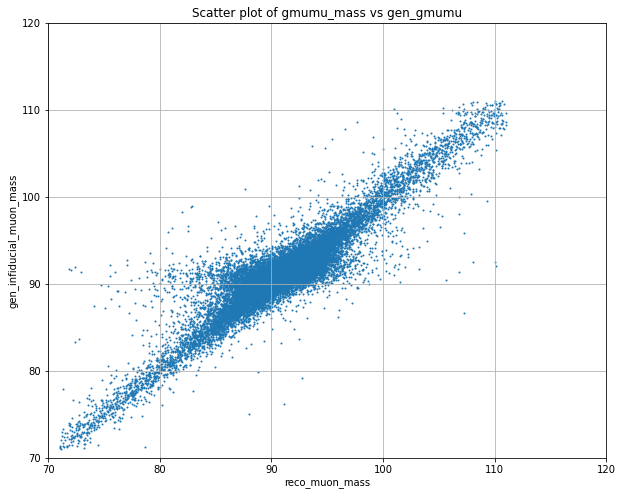

In [11]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入
    # data_subkeys = ['reco_photon_pt','gen_infiducial_photon_pt','reco_muon_mass','gen_infiducial_muon_mass','reco_gmumu_mass','gen_infiducial_gmumu_mass','gen_offfiducial_event_photon_pt','reco_offfiducial_event_muon_mass'
# 提取数据
gmumu_mass = ak.Array(fiducial_final['zg2']['reco_muon_mass'])
gen_gmumu = ak.Array(fiducial_final['zg2']['gen_infiducial_muon_mass'])
# [ak.num(fiducial_final)['zg0']['gen_gmumu'])==1]
# gen_gmumu = ak.Array(fiducial_final)['zg0']['gen_gmumu'][:,0])#[:,0]

# min_len = min(len(gmumu_mass), len(gen_gmumu))
# gmumu_mass = gmumu_mass[:min_len]
# gen_gmumu = gen_gmumu[:min_len]

# 清洗数据: 移除包含nan的数据
# mask = (np.isfinite(ak.to_numpy(gmumu_mass)) & np.isfinite(ak.to_numpy(gen_gmumu)))
gen_gmumu_clean = gen_gmumu
gmumu_mass_clean = gmumu_mass

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(gmumu_mass_clean, gen_gmumu_clean, s=1)
plt.xlabel('reco_muon_mass')
plt.ylabel('gen_infiducial_muon_mass')
plt.title('Scatter plot of gmumu_mass vs gen_gmumu')
plt.grid(True)
plt.xlim(70,120)
plt.ylim(70,120)
plt.show()


In [24]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入
    # data_subkeys = ['reco_photon_pt','gen_infiducial_photon_pt','reco_muon_mass','gen_infiducial_muon_mass','reco_gmumu_mass','gen_infiducial_gmumu_mass','reco_offfiducial_photon_pt','reco_offfiducial_muon_mass','gen_offfiducial_photon_pt','reco_offfiducial_muon_mass']
# 提取数据
gmumu_mass = ak.Array(fiducial_final['zg2']['reco_offfiducial_photon_pt'])
gen_gmumu = ak.Array(fiducial_final['zg2']['gen_offfiducial_muon_mass'])
# [ak.num(fiducial_final)['zg0']['gen_gmumu'])==1]
# gen_gmumu = ak.Array(fiducial_final)['zg0']['gen_gmumu'][:,0])#[:,0]

# min_len = min(len(gmumu_mass), len(gen_gmumu))
# gmumu_mass = gmumu_mass[:min_len]
# gen_gmumu = gen_gmumu[:min_len]

# 清洗数据: 移除包含nan的数据
# mask = (np.isfinite(ak.to_numpy(gmumu_mass)) & np.isfinite(ak.to_numpy(gen_gmumu)))
gen_gmumu_clean = gen_gmumu
gmumu_mass_clean = gmumu_mass

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(gmumu_mass_clean, gen_gmumu_clean, s=1)
plt.xlabel('gmumu_mass')
plt.ylabel('gen_gmumu')
plt.title('Scatter plot of gmumu_mass vs gen_gmumu')
plt.grid(True)
plt.xlim(70,120)
plt.ylim(70,120)
plt.show()


KeyError: 'gen_offfiducial_muon_mass'

ValueError: x and y must be the same size

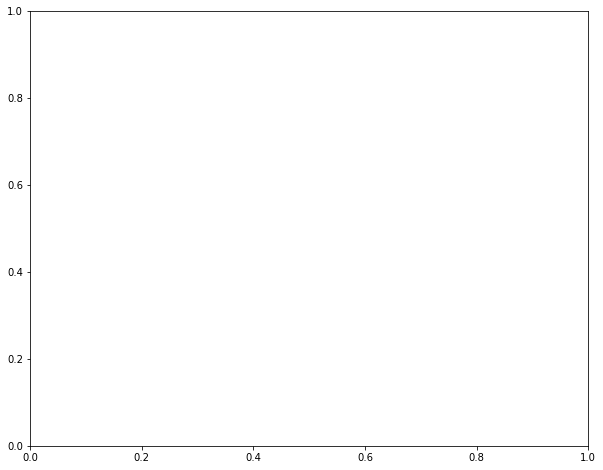

In [24]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
gmumu_mass = ak.Array(event_final['zg0']['gmumu_mass'])
gen_gmumu = ak.Array(event_final['zg0']['gen_gmumu'])[ak.num(event_final['zg0']['gen_gmumu'])==1]
# gen_gmumu = ak.Array(event_final['zg0']['gen_gmumu'][:,0])#[:,0]

# 清洗数据: 移除包含nan的数据
# mask = (np.isfinite(ak.to_numpy(gmumu_mass)) & np.isfinite(ak.to_numpy(gen_gmumu)))
# gmumu_mass_clean = gmumu_mass[mask]
gen_gmumu_clean = gen_gmumu
gmumu_mass_clean = gmumu_mass


# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(gmumu_mass_clean, gen_gmumu_clean, s=1)  
# plt.scatter(gmumu_mass, gen_gmumu, s=1)
plt.xlabel('gmumu_mass')
plt.ylabel('gen_gmumu')
plt.title('Scatter plot of gmumu_mass vs gen_gmumu')
plt.grid(True)
plt.xlim(50,600)
plt.ylim(50,600)
plt.show()


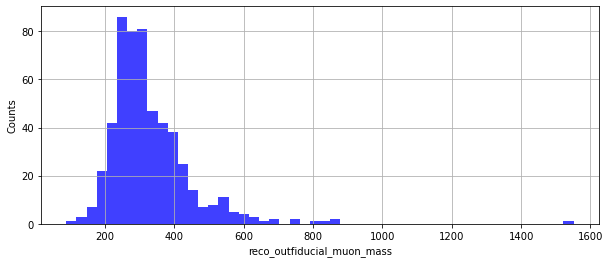

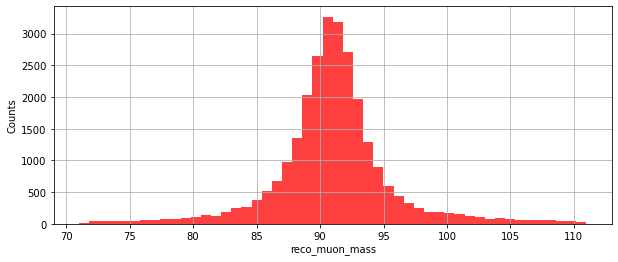

In [13]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np


# 提取数据
gmumu_mass = ak.Array(fiducial_final['zg2']['reco_outfiducial_muon_mass'])#reco_offfiducial_muon_mass
gen_gmumu = ak.Array(fiducial_final['zg2']['reco_muon_mass'])

# 清洗数据: 移除包含nan的数据
# mask = (np.isfinite(ak.to_numpy(gmumu_mass)) & np.isfinite(ak.to_numpy(gen_gmumu)))
gmumu_mass_clean = gmumu_mass
gen_gmumu_clean = gen_gmumu

# 创建一维的 gmumu_mass 散点图/直方图
plt.figure(figsize=[10, 4])
plt.hist(gmumu_mass_clean, bins=50, alpha=0.75, color='blue')  # 可以自定义bins的数量以及颜色等属性
plt.xlabel('reco_outfiducial_muon_mass')
plt.ylabel('Counts')
plt.grid(True)
plt.show()

# 创建一维的 gen_gmumu 散点图/直方图
plt.figure(figsize=[10, 4])
plt.hist(gen_gmumu_clean, bins=50, alpha=0.75, color='red')  # 可以自定义bins的数量以及颜色等属性
plt.xlabel('reco_muon_mass')
plt.ylabel('Counts')
plt.grid(True)
plt.show()


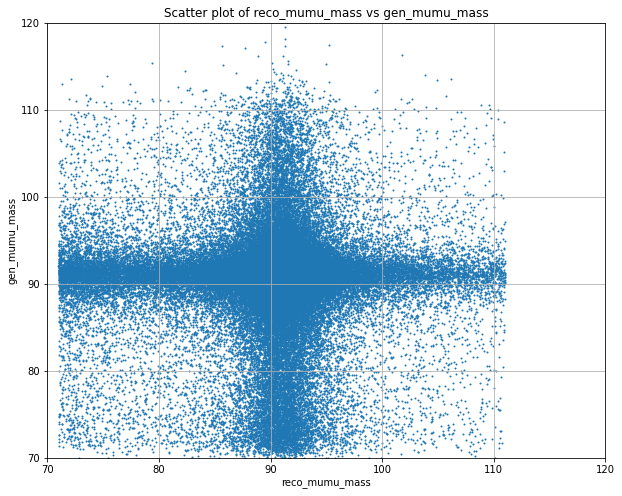

In [31]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
gmumu_mass = ak.Array(event_final['zg0']['muon_mass'])
# gen_gmumu = ak.Array(event_final['zg0']['gen_mumu'])
gen_gmumu = ak.Array(event_final['zg0']['gen_mumu'])

# gen_gmumu = ak.Array(event_final['zg0']['gen_gmumu'][:,0])#[:,0]

min_len = min(len(gmumu_mass), len(gen_gmumu))
gmumu_mass = gmumu_mass[:min_len]
gen_gmumu = gen_gmumu[:min_len]


# 清洗数据: 移除包含nan的数据
mask = (np.isfinite(ak.to_numpy(gmumu_mass)) & np.isfinite(ak.to_numpy(gen_gmumu)))
gmumu_mass_clean = gmumu_mass[mask]
gen_gmumu_clean = gen_gmumu[mask]

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(gmumu_mass_clean, gen_gmumu_clean, s=1)  
plt.xlabel('reco_mumu_mass')
plt.ylabel('gen_mumu_mass')
plt.title('Scatter plot of reco_mumu_mass vs gen_mumu_mass')
plt.grid(True)
plt.xlim(70,120)
plt.ylim(70,120)
plt.show()


ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

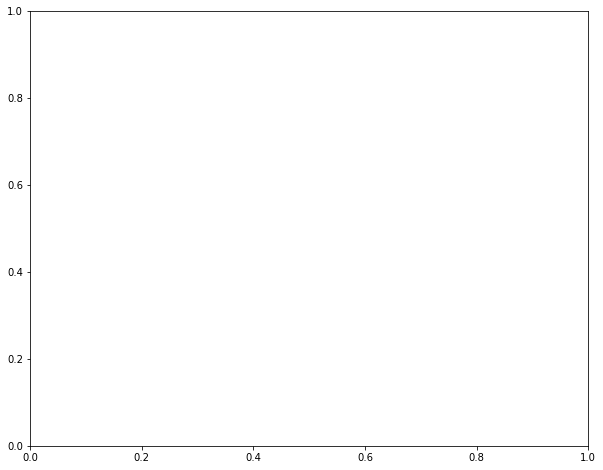

In [36]:

# 提取数据
photon_pt = ak.Array(event_final['zg0']['photon_pt'])
# gen_photon_pt = ak.Array(event_final['zg0']['gen_photon_pt'])
gen_photon_pt = ak.Array(event_final['zg0']['GenIsolatedPhoton']['pt'])


# 清洗数据: 移除包含nan的数据
# mask = (np.isfinite(ak.to_numpy(photon_pt)) & np.isfinite(ak.to_numpy(gen_photon_pt)))
photon_pt_clean = photon_pt
gen_photon_pt_clean = gen_photon_pt

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(photon_pt_clean, gen_photon_pt_clean, s=1)  
plt.xlabel('photon_pt')
plt.ylabel('gen_photon_pt')
plt.title('Scatter plot of photon_pt vs gen_photon_pt')
plt.grid(True)
plt.xlim(70,200)
plt.ylim(70,200)
plt.show()

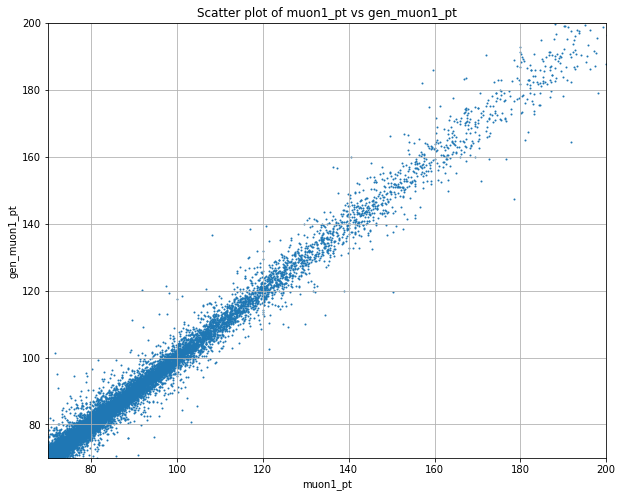

In [38]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
muon1_pt = ak.Array(event_final['zg0']['muon1_pt'])
# gen_muon1_pt = ak.Array(event_final['zg0']['gen_muon1_pt'])
gen_muon1_pt = ak.Array(event_final['zg0']['GenDressedLepton']['pt'][:,0])


# 清洗数据: 移除包含nan的数据
mask = (np.isfinite(ak.to_numpy(muon1_pt)) & np.isfinite(ak.to_numpy(gen_muon1_pt)))
muon1_pt_clean = muon1_pt[mask]
gen_muon1_pt_clean = gen_muon1_pt[mask]

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(muon1_pt_clean, gen_muon1_pt_clean, s=1)  
plt.xlabel('muon1_pt')
plt.ylabel('gen_muon1_pt')
plt.title('Scatter plot of muon1_pt vs gen_muon1_pt')
plt.grid(True)
plt.xlim(70,200)
plt.ylim(70,200)
plt.show()


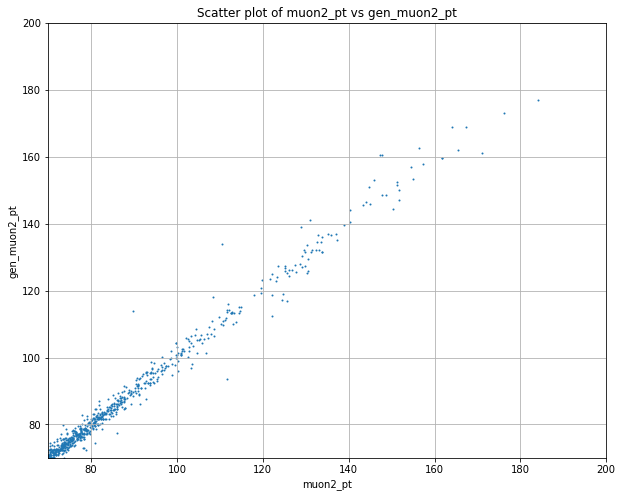

In [67]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
muon2_pt = ak.Array(event_final['zg0']['muon2_pt'])
gen_muon2_pt = ak.Array(event_final['zg0']['gen_muon2_pt'])

# 清洗数据: 移除包含nan的数据
mask = (np.isfinite(ak.to_numpy(muon2_pt)) & np.isfinite(ak.to_numpy(gen_muon2_pt)))
muon2_pt_clean = muon2_pt[mask]
gen_muon2_pt_clean = gen_muon2_pt[mask]

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(muon2_pt_clean, gen_muon2_pt_clean, s=1)  
plt.xlabel('muon2_pt')
plt.ylabel('gen_muon2_pt')
plt.title('Scatter plot of muon2_pt vs gen_muon2_pt')
plt.grid(True)
plt.xlim(70,200)
plt.ylim(70,200)
plt.show()


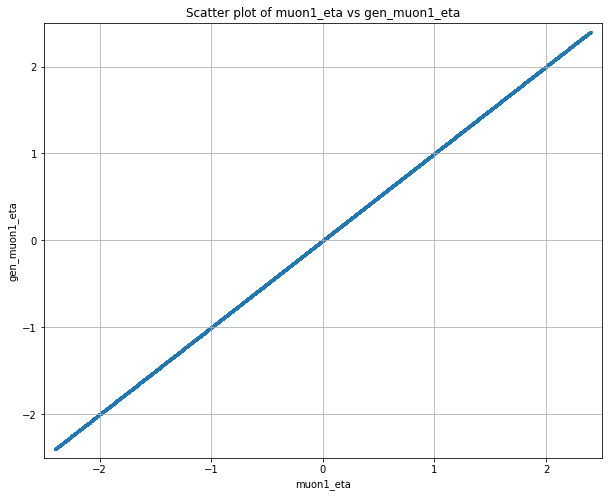

In [68]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
muon1_eta = ak.Array(event_final['zg0']['muon1_eta'])
gen_muon1_eta = ak.Array(event_final['zg0']['gen_muon1_eta'])

# 清洗数据: 移除包含nan的数据
mask = (np.isfinite(ak.to_numpy(muon1_eta)) & np.isfinite(ak.to_numpy(gen_muon1_eta)))
muon1_eta_clean = muon1_eta[mask]
gen_muon1_eta_clean = gen_muon1_eta[mask]

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(muon1_eta_clean, gen_muon1_eta_clean, s=1)  
plt.xlabel('muon1_eta')
plt.ylabel('gen_muon1_eta')
plt.title('Scatter plot of muon1_eta vs gen_muon1_eta')
plt.grid(True)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.show()


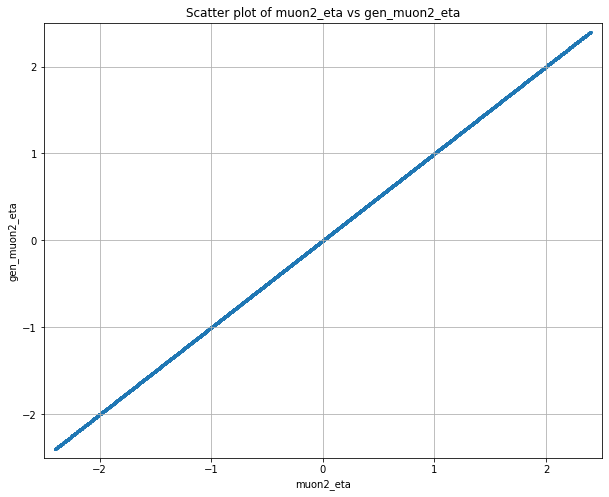

In [69]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np  # 这是新的导入

# 提取数据
muon2_eta = ak.Array(event_final['zg0']['muon2_eta'])
gen_muon2_eta = ak.Array(event_final['zg0']['gen_muon2_eta'])

# 清洗数据: 移除包含nan的数据
mask = (np.isfinite(ak.to_numpy(muon2_eta)) & np.isfinite(ak.to_numpy(gen_muon2_eta)))
muon2_eta_clean = muon2_eta[mask]
gen_muon2_eta_clean = gen_muon2_eta[mask]

# 创建散点图
plt.figure(figsize=[10, 8])
plt.scatter(muon2_eta_clean, gen_muon2_eta_clean, s=1)  
plt.xlabel('muon2_eta')
plt.ylabel('gen_muon2_eta')
plt.title('Scatter plot of muon2_eta vs gen_muon2_eta')
plt.grid(True)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.show()


In [ ]:
lepton = ak.Array(fiducial_fical['zg2']['GenDressedLepton'])
photon = ak.Array(fiducial_fical['zg2']['GenIsolatedPhoton'])
sample0 = ak.Array(fiducial_fical['zg2'])
# 'reco_muon_mass','gen_infiducial_muon_mass'
print('begin',len(sample0))
pass_mu = lepton.pt > 10
pass_pho = photon.pt > 10
ak.num(pass_mu)
sample1 = ak.Array(sample0[(ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2)])
failed1 = ak.Array(sample0[~((ak.num(pass_pho,axis=1)==1) & (ak.num(pass_mu,axis=1)==2))])
print('1 photon+2 muons',len(sample1))
print('Failed after 1 photon+2 muons',len(failed1))
sample_tem = sample1['GenDressedLepton'][abs(sample1['GenDressedLepton'].eta) < 2.4]
sample2 = sample1[ak.num(sample_tem.eta)==2]
failed2 = sample1[~(ak.num(sample_tem.eta)==2)]
print('abs(eta) < 2.4',len(sample2))
print('Failed after abs(eta) < 2.4',len(failed2))
sample_tem = sample2['GenDressedLepton'][(sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20)]
sample3 = sample2[ak.num(sample_tem.pt)==2]
# sample3 = sample2[(sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20)]
# failed3 = sample2[~((sample2['GenDressedLepton'].pt[:,0]>=25) & (sample2['GenDressedLepton'].pt[:,1]>=20))]
print('pt >= 25,20',len(sample3))
print('Failed after pt >= 25,20',len(failed3))
sample4 = sample3[ak.sum(sample3['GenDressedLepton'].pdgId,axis=1)==0]
failed4 = sample3[~(ak.sum(sample3['GenDressedLepton'].pdgId,axis=1)==0)]
print('opposite charge',len(sample4))
print('Failed after opposite charge',len(failed4))
# mass_mumu = selection_cut.MASS(sample4,'mu')
sample_tem = sample4['GenIsolatedPhoton'][sample4['GenIsolatedPhoton'].pt > 30]
sample5 = sample4[ak.num(sample_tem.eta)==1]
failed5 = sample4[~(ak.num(sample_tem.eta)==1)]
print('photon pt >30',len(sample5))
print('Failed after photon pt >30',len(failed5))
sample_tem = sample5['GenIsolatedPhoton'][(abs(sample5['GenIsolatedPhoton'].eta) < 2.5) & ~((abs(sample5['GenIsolatedPhoton'].eta) > 1.4442) & (abs(sample5['GenIsolatedPhoton'].eta) < 1.566))]
sample6 = sample5[ak.num(sample_tem.eta)==1]
failed6 = sample5[~(ak.num(sample_tem.eta)==1)]
print('photon eta',len(sample6))
print('Failed after photon eta',len(failed6))
print('Acceptance :', len(sample6)/len(sample0))
all_failed = ak.concatenate([failed1, failed2, failed3, failed4, failed5, failed6], axis=0)
print('Total failed events:', len(all_failed))
# lg_near, lg_dr = sample6['GenIsolatedPhoton'].nearest(sample6['GenDressedLepton'], axis=1, return_metric=True)
# lg_dr
# fsr = selection_cut.muon(pho5,'fsr',lg_dr)